In [8]:
# Necessary imports
import itertools
import json
import numpy as np
import matplotlib.pyplot as plt
from cribbage import *

%matplotlib inline

In [9]:
deck = MakeDeck()
game = Cribbage()
crib_scores = {i: 0 for i in deck}

## Cribbing analysis

When players are choosing what cards to discard into their crib, there are good and bad choices. Adding a 5 is a good choice, for example, as 10-value cards are the most common and the player will likely score on 15s. The player who owns the crib wants to maximise this score, and the other player wants to minimise this. 

Since the number of combinations of cards is fairly small - $ {52 \choose 5} = 2598960 $ - we can work out the value of adding any card to the crib by going through each hand and taking the sum of the scores of every hand each card appears in. The issue is thrown when you consider that because of the structure of having the last card of the hand be the crib card, I have to check the value of the hand twice when a Jack is in the hand (to check whether *One for his knob* is scored or not). 

In [21]:
#FIXME the jack hands are run more times than non-jack hands, which boosts the jacks 

# Precomputing the value of every card in the crib
print(f"Number of hands: > {len(tuple(itertools.combinations(deck, 5)))}")
for c, i in enumerate(itertools.combinations(deck, 5)):
    # Progress Check
    if c % 500000 == 0:
        print(f"Progress: {c}")
    x = list(i)
    # Combinations with a Jack must be checked with the Jack in and out of
    # The last position
    jacks = []
    for c, card in enumerate(x):
        if card[0] == "J":
            jacks.append(c)

    # A hand with n jacks must be divided by n + 1 to keep scoring fair across
    # hands, since hands with a jack are scored n + 1 times
    if len(jacks) == 0:
        score = game.ScoreHand(x)
        for j in i:
            crib_scores[j] += score
    elif len(jacks) == 1:
        score = game.ScoreHand(x)
        for j in i:
            crib_scores[j] += score / 2
        jack_list = x.copy()
        if jacks[0] == 4:
            jack_list[0], jack_list[4] = jack_list[4], jack_list[0]
        else:
            jack_list[jacks[0]], jack_list[-1] = jack_list[-1], jack_list[jacks[0]]
        score = game.ScoreHand(x)
        for j in i:
            crib_scores[j] += score / 2
    else:
        jack_list = x.copy()
        if 4 in jacks:
            for jack in jacks:
                score = game.ScoreHand(x)
                for j in i:
                    crib_scores[j] += score / (len(jacks) + 1)
                jack_list[jack], jack_list[-1] = jack_list[-1], jack_list[jack]
        else:
            for jack in jacks:
                score = game.ScoreHand(x)
                for j in i:
                    crib_scores[j] += score / (len(jacks) + 1)
                jack_list[jack], jack_list[-1] = jack_list[-1], jack_list[jack]
print("Done")

Number of hands: > 2598960
Progress: 0
Progress: 500000
Progress: 1000000
Progress: 1500000
Progress: 2000000
Progress: 2500000
Done


In [22]:
# Writing this to a JSON file for future use to inform cribbing choices in games
with open("cribscores.json", "w") as file:
    file.write(json.dumps(crib_scores))

In [23]:
# Somehow the 5 of spades is the best card ?? 
maximum = max(crib_scores, key=lambda k: crib_scores[k])
minimum = min(crib_scores, key=lambda k: crib_scores[k])

print("Best Cards: ")
for k, v in crib_scores.items():
    if v == crib_scores[maximum]:
        print(k)

print("\n\nWorst Cards: ")
for k, v in crib_scores.items():
    if v == crib_scores[minimum]:
        print(k)


Best Cards: 
5S


Worst Cards: 
KS


In [24]:
# Finding the top and bottom 10 
sorted_scores = sorted(crib_scores.items(), key=lambda x: x[1])
print("Top 10 cards: ")
for i in reversed(sorted_scores[-10:]):
    print(i[0])

print("\n\nWorst Scores: ")
for i in sorted_scores[:10]:
    print(i[0])

Top 10 cards: 
5S
5H
5C
5D
JD
JC
JH
JS
3S
4S


Worst Scores: 
KS
KH
KC
KD
QS
QH
QC
QD
10D
10C


In [25]:
# Ranking all the cards in order
with open("cribscores.json", "r") as file:
    scores = json.loads(file.read())
scores = sorted(scores.items(), key=lambda x:x[1])

for i in reversed(scores):
    print(i[0])

5S
5H
5C
5D
JD
JC
JH
JS
3S
4S
4H
2S
3H
4C
3C
4D
3D
6S
6H
6C
6D
2H
2C
2D
AS
7S
7H
7C
7D
8S
8H
8C
8D
AH
AC
AD
9S
9H
9C
9D
10S
10H
10C
10D
QD
QC
QH
QS
KD
KC
KH
KS


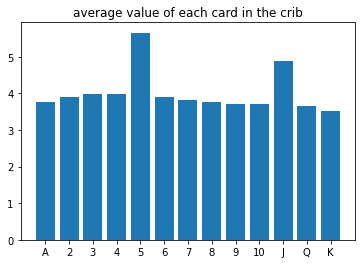

In [26]:
total_scores = [0 for i in range(13)]
for card in scores:
    card_val = card[0][:-1]
    if card_val == "A":
        total_scores[0] += card[1]
    elif card_val == "J":
        total_scores[10] += card[1]
    elif card_val == "Q":
        total_scores[11] += card[1]
    elif card_val == "K":
        total_scores[12] += card[1]
    else:
        total_scores[int(card_val) - 1] += card[1]
    
total_scores = np.array(total_scores)
# There are 2598960 hands total
avg_scores = total_scores / 2598960
values = [str(i) for i in range(1, 14)]
values[0], values[10], values[11], values[12] = "A", "J", "Q", "K"

plt.title("average value of each card in the crib")
plt.bar(values, avg_scores)
plt.show()

In [27]:
avg_scores

array([3.77066002, 3.89970279, 3.96863421, 3.96893933, 5.65601901,
       3.90210952, 3.81054444, 3.76949956, 3.72185627, 3.7013877 ,
       4.89408433, 3.64857988, 3.5070929 ])

### Summary of Cribbing strategy
The data shows clear peaks for 5s and Jacks for the highest scoring cribs. These patterns are because there are a large number of 10 cards, which means a large number of 15s when a 5 is in the crib, and also the *one for his knob* rule. 9s, 10s, Queens and Kings score the least as the higher they get , the less runs can be made. 9 is also so low becuase it narrowly misses out on making 15 with the 5. 

This means that we can begin to look at strategy. When it is your own crib and you are dealt a 5 or a Jack, they should be added to your crib and high cards kept out. When it is someone else's crib, the data suggests you add a 10 card, as they score the least points, but doing so would really benefit your opponent on the chance that they add a 5. Aside from the 5 and Jack, the distribution is very uniform, meaning cards can be added fairly arbitratily. You also have to factor in the detriment to your own hand. Towards the end of the game, it may be important to beat your opponent in play rather than on crib and hands, so your own hand must be taken into account. A player may also choose to sacrifice points in their hand to give their opponent a worse crib. These are strategies that can be experimented with later by overriding the `Cribbage.AddToCrib()` method. 